In [1]:
using PyPlot
using Random
using LsqFit
using FStrings
using DataFrames

In [2]:
P = zeros(50) .+ 0.30
P[1:10] = [0.5, 0.45, 0.45, 0.4, 0.4, 0.4, 0.35, 0.35, 0.35, 0.35];
#P = zeros(50) .+ 0.4; # FOR testing
#P = P .* (1 + 0.0256)

X(n) = P[n+1]
S(N) = N > 0 ? prod(X.(collect(0:(N-1)))) : 1 - X(0)
Z(N) = N > 0 ? (1-X(N))*prod(X.(collect(0:(N-1)))) : 1-X(0)
T(N) = N + 1
# Finally, the thing we're after. Average time to target
TimeToTarget(N) = (sum( Z.(0:N-1) .* T.(0:N-1) ) + S(N)*T(N-1))/S(N)

TimeToTargetProt(N, pro) = pro < N ? TimeToTargetProt(N-1)*10 : TimeToTarget(N)

## What else would we like? Average XP?
## Protection should be interesting, there is an infinite series of rapidly decreasing probability
## So we can use perterbation theory and take only Nth order terms. Start with N=1.

TimeToTargetProt (generic function with 1 method)

In [5]:
## Simulated Values
function enhance(level; crit=0.0)
    if rand() < P[level+1]
        return rand() < crit ? level + 2 : level + 1
    end
    return 0
end

function simulatedEnhance(target; trials=10_000)
    dataset = []
    for t in collect(1:trials)
        count = 0
        level = 0
        while level < target
            count += 1
            level = enhance(level)
        end
        push!(dataset, count)
    end
    return sum(dataset)/length(dataset)
end

function protected(level, select; crit=0.0)
    if level < select
        return enhance(level; crit=crit)
    end
    if rand() < P[level+1]
        return rand() < crit ? level + 2 : level + 1
    end
    return max(0,level - 1)
end

mean(x) = sum(x) / length(x)

function simulatedProtected(target, select; trials=10_000, cost=60, crit=0.0)
    # Cost is ratio of protection cost over enhance cost
    dataset = []
    actionset = []
    protectionset = []
    for t in collect(1:trials)
        count = 0
        level = 0
        actions = 0
        protections = 0
        while level < target
            if level >= select
                count += cost+1
                protections += 1
            else
                count += 1
            end
            actions += 1
            level = protected(level, select; crit=crit)
        end
        push!(dataset, count)
        push!(actionset, actions)
        push!(protectionset, protections)
    end
    return [mean(dataset), mean(actionset), mean(protectionset)]
end

function simulatedProtectedExp(select; trials=10_000, cost=60)
    dataset = []
    for t in collect(1:trials)
        experience = 0
        count = 0
        level = 0
        for t in collect(1:1000)
            if level >= select
                count += cost+1
            else
                count += 1
            end
            lastLevel = level
            level = protected(level, select)
            if level > lastLevel
                experience += level
            end
        end
        push!(dataset, experience/count)
    end
    return sum(dataset)/length(dataset)
end

function fastSim(target, select; trials=10_000)
    dataset = []
    if target <= select
        return TimeToTarget(target)
    end
    for t in collect(1:trials)
        count = TimeToTarget(select)
        level = select
        while level < target
            level = protected(level, select)
            if level < select - 1
                # Reset and boost count
                count += TimeToTarget(select) + 1
                level = select
            else
                count += 1
            end
        end
        push!(dataset, count)
    end
    return sum(dataset)/length(dataset)
end

function simulatedAlpha(target; trials=10_000)
    dataset = []
    for t in collect(1:trials)
        resets = 0
        level = 0
        while level < target
            if( level == 0 )
                resets += 1
            end
            level = enhance(level)
        end
        push!(dataset, resets)
    end
    return sum(dataset)/length(dataset)
end

simulatedAlpha (generic function with 1 method)

In [13]:
@show simulatedProtected(10,6)

simulatedProtected(10, 6) = [8484.7387, 4547.4187, 65.622]


3-element Vector{Float64}:
 8484.7387
 4547.4187
   65.622

In [43]:
x = collect(4:12)
# Cost, Actions, Protections
reg = simulatedProtected.(x, 6; trials=50_000)
crit = simulatedProtected.(x, 6; trials=50_000, crit=0.01)

9-element Vector{Vector{Float64}}:
 [43.20364, 43.20364, 0.0]
 [109.00888, 109.00888, 0.0]
 [270.9833, 270.9833, 0.0]
 [740.47704, 573.47904, 2.7833]
 [1760.42442, 1121.16642, 10.6543]
 [3788.8089, 2127.2757, 27.69222]
 [7684.80304, 3959.83624, 62.08278]
 [16530.19396, 8057.24956, 141.21574]
 [37569.59432, 17718.45392, 330.85234]

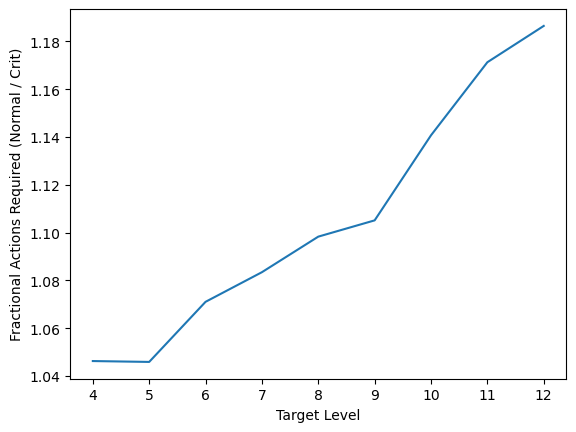

PyObject Text(24.00000000000002, 0.5, 'Fractional Actions Required (Normal / Crit)')

In [46]:
clmn(x, n) = reduce(hcat,x)'[:,n]

regPlt = clmn(reg, 2)
critPlt = clmn(crit, 2)
fracPlt = regPlt ./ critPlt
plt.plot(x, fracPlt)
plt.xlabel("Target Level")
plt.ylabel("Fractional Actions Required (Normal / Crit)")